# Interpolation and Gaussian quadrature



_Polynomial interpolation_ is the process of finding a polynomial that equals data at a precise set of points.
_Quadrature_ is the act of approximating an integral by a weighted sum:
$$
\int_a^b f(x) w(x) {\rm d}x ≈ \sum_{j=1}^n w_j f(x_j).
$$
In these notes we see that the two concepts are intrinsically linked:  interpolation leads naturally
to quadrature rules. Moreover, by using a set of points $x_j$ linked to orthogonal polynomials we get
significantly more accurate rules, and in fact can use quadrature to compute expansions in orthogonal polynomials that
interpolate. That is, we can mirror the link between the Trapezium rule, Fourier series, and interpolation but
now for polynomials.


1. Polynomial Interpolation: we describe how to interpolate a function by a polynomial.
3. Truncated Jacobi matrices: we see that truncated Jacobi matrices are diagonalisable
in terms of orthogonal polynomials and their zeros. 
2. Interpolatory quadrature rule: polynomial interpolation leads naturally to ways to integrate
functions, but onely realisable in the simplest cases.
3. Gaussian quadrature: Using roots of orthogonal polynomials and truncated Jacobi matrices 
leads naturally to an efficiently
computable interpolatory quadrature rule. The _miracle_ is its exact for twice as many polynomials as
expected.



## 1. Polynomial Interpolation

We already saw a special case of polynomial interpolation, where we saw that the polynomial
$$
f(z) ≈ ∑_{k=0}^{n-1} f̂_k^n z^k
$$
equaled $f$ at evenly spaced points on the unit circle: ${\rm e}^{{\rm i} 2π j/n}$. 
But here we consider the following:

**Definition (interpolatory polynomial)** Given $n$ distinct points $x_1,…,x_n ∈ ℝ$ 
and $n$ _samples_ $f_1,…,f_n ∈ ℝ$, a degree $n-1$
_interpolatory polynomial_ $p(x)$ satisfies
$$
p(x_j) = f_j
$$

The easiest way to solve this problem is to invert the Vandermonde system:

**Definition (Vandermonde)** The _Vandermonde matrix_ associated with $n$ distinct points $x_1,…,x_n ∈ ℝ$
is the matrix
$$
V := \begin{bmatrix} 1 & x_1 & ⋯ & x_1^{n-1} \\
                    ⋮ & ⋮ & ⋱ & ⋮ \\
                    1 & x_n & ⋯ & x_n^{n-1}
                    \end{bmatrix}
$$

**Proposition (interpolatory polynomial uniqueness)** 
The interpolatory polynomial is unique, and the Vandermonde matrix is invertible.

**Proof**
Suppose $p$ and $p̃$ are both interpolatory polynomials. Then $p(x) - p̃(x)$ vanishes at $n$ distinct points $x_j$. By the fundamental theorem of
algebra it must be zero, i.e., $p = p̃$.

For the second part, if $V 𝐜 = 0$ for $𝐜 ∈ ℝ$ then for $q(x) = c_1 + ⋯ + c_n x^{n-1}$ we have
$$
q(x_j) = 𝐞_j^⊤ V 𝐜 = 0
$$
hence $q$ vanishes at $n$ distinct points and is therefore 0, i.e., $𝐜 = 0$.

∎

Thus a quick-and-dirty way to to do interpolation is to invert the Vandermonde matrix
(which we saw in the least squares setting with more samples then coefficients):

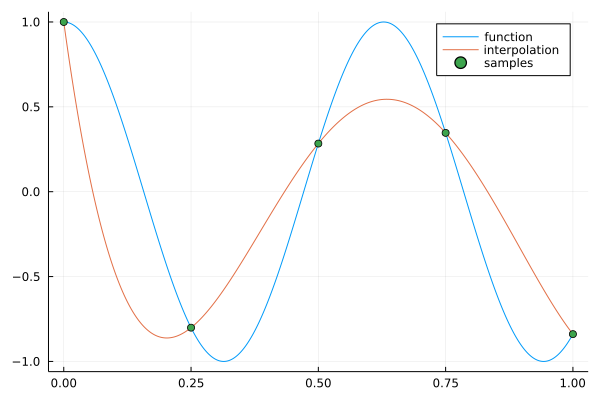

In [1]:
using Plots, LinearAlgebra
f = x -> cos(10x)
n = 5

x = range(0, 1; length=n)# evenly spaced points (BAD for interpolation)
V = x .^ (0:n-1)' # Vandermonde matrix
c = V \ f.(x) # coefficients of interpolatory polynomial
p = x -> dot(c, x .^ (0:n-1))

g = range(0,1; length=1000) # plotting grid
plot(g, f.(g); label="function")
plot!(g, p.(g); label="interpolation")
scatter!(x, f.(x); label="samples")

But it turns out we can also construct the interpolatory polynomial directly.
We will use the following with equal $1$ at one grid point
and are zero at the others:

**Definition (Lagrange basis polynomial)** The _Lagrange basis polynomial_ is defined as
$$
ℓ_k(x) := ∏_{j ≠ k} {x-x_j \over x_k - x_j} =  {(x-x_1) ⋯(x-x_{k-1})(x-x_{k+1}) ⋯ (x-x_n) \over (x_k - x_1) ⋯ (x_k - x_{k-1}) (x_k - x_{k+1}) ⋯ (x_k - x_n)}
$$

Plugging in the grid points verifies the following:

**Proposition (delta interpolation)**
$$
ℓ_k(x_j) = δ_{kj}
$$

We can use these to construct the interpolatory polynomial:

**Theorem (Lagrange interpolation)**
The unique  polynomial of degree at most $n-1$ that interpolates $f$ at $n$ distinct
points $x_j$ is:
$$
p(x) = f(x_1) ℓ_1(x) + ⋯ + f(x_n) ℓ_n(x)
$$

**Proof**
Note that
$$
p(x_j) = ∑_{j=1}^n f(x_j) ℓ_k(x_j) = f(x_j)
$$
so we just need to show it is unique. Suppose $p̃(x)$ is a  polynomial
of degree at most $n-1$
that also interpolates $f$. Then $p̃ - p$ vanishes at $n$ distinct points.
Thus by the fundamental theorem of algebra it must be zero.


∎

**Example** We can interpolate $\exp(x)$ at the points $0,1,2$:
$$
\begin{align*}
p(x) &= ℓ_1(x) + {\rm e} ℓ_2(x) + {\rm e}^2 ℓ_3(x) =
{(x - 1) (x-2) \over (-1)(-2)} + {\rm e} {x (x-2) \over (-1)} +
{\rm e}^2 {x (x-1) \over 2} \\
&= (1/2 - {\rm e} +{\rm e}^2/2)x^2 + (-3/2 + 2 {\rm e}  - {\rm e}^2 /2) x + 1
\end{align*}
$$


**Remark** Interpolating at evenly spaced points is a really **bad** idea:
interpolation is inheritely ill-conditioned. 
The problem sheet asks you to explore
this experimentally.

## 2. Roots of orthogonal polynomials and truncated Jacobi matrices

We now consider roots (zeros) of orthogonal polynomials $p_n(x)$. This is important as we shall
see they are useful for interpolation and quadrature. For interpolation to be well-defined we
first need to guarantee that the roots are distinct.

**Lemma** An orthogonal polynomial $p_n(x)$ has exactly $n$ distinct roots.

**Proof**

Suppose $x_1, …,x_j$ are the roots where $q_n(x)$ changes sign, that is,
$$
p_n(x) = c_k (x-x_k)^{2p+1} + O((x-x_k)^{2p+2})
$$
for $c_k ≠ 0$ and $k = 1,…,j$ and $p ∈ ℤ$, as$x → x_k$. Then
$$
p_n(x) (x-x_1) ⋯(x-x_j)
$$
does not change signs: it behaves like $c_k (x-x_k)^{2p+2} + O(x-x_k)^{2p+3}$ as $x → x_k$.
In other words:
$$
⟨p_n,(x-x_1) ⋯(x-x_j) ⟩ = \int_a^b p_n(x) (x-x_1) ⋯(x-x_j) w(x) {\rm d} x ≠ 0.
$$
where $w(x)$ is the weight of orthogonality.
This is only possible if $j = n$ as $p_n(x)$ is orthogonal w.r.t. all lower degree
polynomials.

∎

**Definition (truncated Jacobi matrix)** Given a symmetric Jacobi matrix $X$,
(or the weight $w(x)$ whose orthonormal polynomials are associated with $X$)
 the _truncated Jacobi matrix_ is
$$
X_n := \begin{bmatrix} a_0 & b_0 \\
                         b_0 & ⋱ & ⋱ \\
                         & ⋱ & a_{n-2} & b_{n-2} \\
                         && b_{n-2} & a_{n-1} \end{bmatrix} ∈ ℝ^{n × n}
$$



**Lemma (zeros)** The zeros $x_1, …,x_n$ of an orthonormal polynomial $q_n(x)$
are the eigenvalues of the truncated Jacobi matrix $X_n$.
More precisely,
$$
X_n Q_n = Q_n \begin{bmatrix} x_1 \\ & ⋱ \\ && x_n \end{bmatrix}
$$
for the orthogonal matrix
$$
Q_n = \begin{bmatrix}
q_0(x_1) & ⋯ & q_0(x_n) \\
⋮  & ⋯ & ⋮  \\
q_{n-1}(x_1) & ⋯ & q_{n-1}(x_n)
\end{bmatrix} \begin{bmatrix} α_1^{-1} \\ & ⋱ \\ && α_n^{-1} \end{bmatrix}
$$
where $α_j = \sqrt{q_0(x_j)^2 + ⋯ + q_{n-1}(x_j)^2}$.

**Proof**

We construct the eigenvector (noting $b_{n-1} q_n(x_j) = 0$):
$$
X_n \begin{bmatrix} q_0(x_j) \\ ⋮ \\ q_{n-1}(x_j) \end{bmatrix} =
\begin{bmatrix} a_0 q_0(x_j) + b_0 q_1(x_j) \\
 b_0 q_0(x_j) + a_1 q_1(x_j) + b_1 q_2(x_j) \\
⋮ \\
b_{n-3} q_{n-3}(x_j) + a_{n-2} q_{n-2}(x_j) + b_{n-2} q_{n-1}(x_j) \\
b_{n-2} q_{n-2}(x_j) + a_{n-1} q_{n-1}(x_j) + b_{n-1} q_n(x_j)
\end{bmatrix} = x_j \begin{bmatrix} q_0(x_j) \\
 q_1(x_j) \\
⋮ \\
q_{n-1}(x_j)
\end{bmatrix}
$$
The result follows from normalising the eigenvectors. Since $X_n$ is symmetric
the eigenvector matrix is orthogonal.

∎

**Example (Chebyshev roots)** Consider $T_n(x) = \cos n {\rm acos}\, x$. The roots 
are $x_j = \cos θ_j$ where $θ_j = (j-1/2)π/n$ for $j = 1,…,n$ are the roots of $\cos n θ$
that are inside $[0,π]$. 

Consider the $n = 3$ case where we have
$$
x_1,x_2,x_3 = \cos(π/6),\cos(π/2),\cos(5π/6) = \sqrt{3}/2,0,-\sqrt{3/2}
$$
We also have from the 3-term recurrence:
$$
\begin{align*}
T_0(x) = 1 \\
T_1(x) = x \\
T_2(x) = 2x T_1(x) - T_0(x) = 2x^2-1 \\
T_3(x) = 2x T_2(x) - T_1(x) = 4x^2-3x
\end{align*}
$$
We orthonormalise by rescaling
$$
\begin{align*}
q_0(x) &= 1/\sqrt{π} \\
q_k(x) &= T_k(x) \sqrt{2}/\sqrt{π}
\end{align*}
$$
so that the Jacobi matrix is symmetric:
$$
x [q_0(x)|q_1(x)|⋯] = [q_0(x)|q_1(x)|⋯] \underbrace{\begin{bmatrix} 0 & 1/\sqrt{2} \\
                            1/\sqrt{2} & 0 & 1/2 \\
                            &1/2 & 0 & 1/2 \\
                             &   & 1/2 & 0 & ⋱ \\
                              &  && ⋱ & ⋱
\end{bmatrix}}_X
$$
We can then confirm that we have constructed an eigenvector/eigenvalue of the $3 × 3$ truncation of the Jacobi matrix,
e.g. at $x_2 = 0$:
$$
\begin{bmatrix} 
0 & 1/\sqrt{2} \\
1/\sqrt{2} & 0 & 1/2 \\
    & 1/2 & 0\end{bmatrix} \begin{bmatrix} q_0(0) \\ q_1(0) \\ q_2(0) 
    \end{bmatrix} = {1 \over \sqrt π} \begin{bmatrix} 
0 & 1/\sqrt{2} \\
1/\sqrt{2} & 0 & 1/2 \\
    & 1/2 & 0\end{bmatrix} \begin{bmatrix} 1 \\ 0 \\ -{1 \over \sqrt{2}}
    \end{bmatrix} =\begin{bmatrix} 0 \\ 0 \\ 0
    \end{bmatrix}
$$



## 3. Interpolatory quadrature rules

**Definition (interpolatory quadrature rule)** Given a set of points $𝐱 = [x_1,…,x_n]$
the interpolatory quadrature rule is:
$$
Σ_n^{w,𝐱}[f] := ∑_{j=1}^n w_j f(x_j)
$$
where
$$
w_j := ∫_a^b ℓ_j(x) w(x) {\rm d} x
$$


**Proposition (interpolatory quadrature is exact for polynomials)** 
Interpolatory quadrature is exact for all degree $n-1$ polynomials $p$:
$$
∫_a^b p(x) w(x) {\rm d}x = Σ_n^{w,𝐱}[f]
$$

**Proof**
The result follows since, by uniqueness of interpolatory polynomial:
$$
p(x) = ∑_{j=1}^n p(x_j) ℓ_j(x)
$$

∎

**Example (arbitrary points)** Find the interpolatory quadrature rule for $w(x) = 1$ on $[0,1]$ with  points $[x_1,x_2,x_3] = [0,1/4,1]$?
We have:
$$
\begin{align*}
w_1 = \int_0^1 w(x) ℓ_1(x) {\rm d}x  = \int_0^1 {(x-1/4)(x-1) \over (-1/4)(-1)}{\rm d}x = -1/6 \\
w_2 = \int_0^1 w(x) ℓ_2(x) {\rm d}x  = \int_0^1 {x(x-1) \over (1/4)(-3/4)}{\rm d}x = 8/9 \\
w_3 = \int_0^1 w(x) ℓ_3(x) {\rm d}x  = \int_0^1 {x(x-1/4) \over 3/4}{\rm d}x = 5/18
\end{align*}
$$
That is we have
$$
Σ_n^{w,𝐱}[f]  = -{f(0) \over 6} + {8f(1/4) \over 9} + {5 f(1) \over 18}
$$
This is indeed exact for polynomials up to degree $2$ (and no more):
$$
Σ_n^{w,𝐱}[1] = 1, Σ_n^{w,𝐱}[x] = 1/2, Σ_n^{w,𝐱}[x^2] = 1/3, Σ_n^{w,𝐱}[x^3] = 7/24 ≠ 1/4.
$$

**Example (Chebyshev roots)** Find the interpolatory quadrature rule for $w(x) = 1/\sqrt{1-x^2}$ on $[-1,1]$ with points equal to the
roots of $T_3(x)$. This is a special case of Gaussian quadrature which we will approach in another way below. We use:
$$
\int_{-1}^1 w(x) {\rm d}x = π, \int_{-1}^1 xw(x) {\rm d}x = 0, \int_{-1}^1 x^2 w(x) {\rm d}x = {π/2}
$$
Recall from before that $x_1,x_2,x_3 = \sqrt{3}/2,0,-\sqrt{3}/2$. Thus we have:
$$
\begin{align*}
w_1 = \int_{-1}^1 w(x) ℓ_1(x) {\rm d}x = \int_{-1}^1 {x(x+\sqrt{3}/2) \over (\sqrt{3}/2) \sqrt{3} \sqrt{1-x^2}}{\rm d}x = {π \over 3} \\
w_2 = \int_{-1}^1 w(x) ℓ_2(x) {\rm d}x = \int_{-1}^1 {(x-\sqrt{3}/2)(x+\sqrt{3}/2) \over (-3/4)\sqrt{1-x^2}}{\rm d}x = {π \over 3} \\
w_3 = \int_{-1}^1 w(x) ℓ_3(x) {\rm d}x = \int_{-1}^1 {(x-\sqrt{3}/2) x \over (-\sqrt{3})(-\sqrt{3}/2) \sqrt{1-x^2}}{\rm d}x = {π \over 3}
\end{align*}
$$
(It's not a coincidence that they are all the same but this will differ for roots of other OPs.) 
That is we have
$$
Σ_n^{w,𝐱}[f]  = {π \over 3}(f(\sqrt{3}/2) + f(0) + f(-\sqrt{3}/2)
$$
This is indeed exact for polynomials up to degree $n-1=2$, but it goes all the way up to $2n-1 = 5$:
$$
\begin{align*}
Σ_n^{w,𝐱}[1] &= π, Σ_n^{w,𝐱}[x] = 0, Σ_n^{w,𝐱}[x^2] = {π \over 2}, \\
Σ_n^{w,𝐱}[x^3] &= 0, Σ_n^{w,𝐱}[x^4] &= {3 π \over 8}, Σ_n^{w,𝐱}[x^5] = 0 \\
Σ_n^{w,𝐱}[x^6] &= {9 π \over 32} ≠ {5 π \over 16}
\end{align*}
$$
We shall explain this miracle next.





## 4. Gaussian quadrature

Gaussian quadrature is the interpolatory quadrature rule corresponding
to the grid $x_j$ defined as the roots of the orthonormal polynomial $q_n(x)$.
We shall see that it is exact for polynomials up to degree $2n-1$, i.e., double
the degree of other interpolatory quadrature rules from other grids.



**Definition (Gauss quadrature)** Given a weight $w(x)$, the Gauss quadrature rule is:
$$
∫_a^b f(x)w(x) {\rm d}x ≈ \underbrace{∑_{j=1}^n w_j f(x_j)}_{Σ_n^w[f]}
$$
where $x_1,…,x_n$ are the roots of the orthonormal polynomials $q_n(x)$ and 
$$
w_j := {1 \over α_j^2} = {1 \over q_0(x_j)^2 + ⋯ + q_{n-1}(x_j)^2}.
$$
Equivalentally, $x_1,…,x_n$ are the eigenvalues of $X_n$ and
$$
w_j = ∫_a^b w(x) {\rm d}x Q_n[1,j]^2.
$$
(Note we have $∫_a^b w(x) {\rm d} x q_0(x)^2 = 1$.)

In analogy to how Fourier series are orthogonal with respect to Trapezium rule,
Orthogonal polynomials are orthogonal with respect to Gaussian quadrature:

**Lemma (Discrete orthogonality)**
For $0 ≤ ℓ,m ≤ n-1$, the orthonormal polynomials $q_n(x)$ satisfy
$$
Σ_n^w[q_ℓ q_m] = δ_{ℓm}
$$

**Proof**
$$
Σ_n^w[q_ℓ q_m] = ∑_{j=1}^n {q_ℓ(x_j) q_m(x_j) \over α_j^2}
= \left[q_ℓ(x_1)/ α_1 | ⋯ | {q_ℓ(x_n)/ α_n}\right] 
\begin{bmatrix}
q_m(x_1)/α_1 \\
⋮ \\
q_m(x_n)/α_n \end{bmatrix} = 𝐞_ℓ Q_n Q_n^⊤ 𝐞_m = δ_{ℓm}
$$

∎

Just as approximating Fourier coefficients using Trapezium rule gives a way of
interpolating at the grid, so does Gaussian quadrature:

**Theorem (interpolation via quadrature)**
For the orthonormal polynomials $q_n(x)$,
$$
f_n(x) = ∑_{k=0}^{n-1} c_k^n q_k(x)\hbox{ for } c_k^n := Σ_n^w[f q_k]
$$
interpolates $f(x)$ at the Gaussian quadrature points $x_1,…,x_n$.

**Proof**

Consider the Vandermonde-like matrix:
$$
Ṽ := \begin{bmatrix} q_0(x_1) & ⋯ & q_{n-1}(x_1) \\
                ⋮ & ⋱ & ⋮ \\
                q_0(x_n) & ⋯ & q_{n-1}(x_n) \end{bmatrix}
$$
and define
$$
Q_n^w := Ṽ^⊤ \begin{bmatrix} w_1 \\ &⋱ \\&& w_n \end{bmatrix} = \begin{bmatrix} q_0(x_1)w_1 & ⋯ &  q_0(x_n) w_n \\
                ⋮ & ⋱ & ⋮ \\
                w_1q_{n-1}(x_1) & ⋯ & q_{n-1}(x_n)w_n \end{bmatrix}
$$
so that
$$
\begin{bmatrix}
c_0^n \\
⋮ \\
c_{n-1}^n \end{bmatrix} = Q_n^w \begin{bmatrix} f(x_1) \\ ⋮ \\ f(x_n) \end{bmatrix}.
$$
Note that if $p(x) = [q_0(x) | ⋯ | q_{n-1}(x)] 𝐜$ then
$$
\begin{bmatrix}
p(x_1) \\
⋮ \\
p(x_n)
\end{bmatrix} = Ṽ 𝐜
$$
But we see that (similar to the Fourier case)
$$
Q_n^w Ṽ = \begin{bmatrix} Σ_n^w[q_0 q_0] & ⋯ & Σ_n^w[q_0 q_{n-1}]\\
                ⋮ & ⋱ & ⋮ \\
                Σ_n^w[q_{n-1} q_0] & ⋯ & Σ_n^w[q_{n-1} q_{n-1}]
                \end{bmatrix} = I_n
$$

∎

**Corollary** Gaussian quadrature is an interpolatory quadrature rule
with the interpolation points equal to the roots of $q_n$:
$$
Σ_n^w[f] = Σ_n^{w,𝐱}[f]
$$
**Proof**
We want to show its the same as integrating the interpolatory polynomial:
$$
\int_a^b f_n(x) w(x) {\rm d}x = {1 \over q_0(x)} \sum_{k=0}^{n-1} c_k^n \int_a^b q_k(x) q_0(x) w(x) {\rm d}x
= {c_0^n \over q_0} = Σ_n^w[f].
$$
∎



A consequence of being an interpolatory quadrature rule is that it is exact for all
polynomials of degree $n-1$. The _miracle_ of Gaussian quadrature is it is exact for twice
as many!



**Theorem (Exactness of Gauss quadrature)** If $p(x)$ is a degree $2n-1$ polynomial then
Gauss quadrature is exact:
$$
∫_a^b p(x)w(x) {\rm d}x = Σ_n^w[p].
$$

**Proof**
Using polynomial division algorithm (e.g. by matching terms) we can write
$$
p(x) = q_n(x) s(x) + r(x)
$$
where $s$ and $r$ are degree $n-1$ and $q_n(x)$ is the degree $n$ orthonormal polynomial. Then we have:
$$
\begin{align*}
Σ_n^w[p] &= \underbrace{Σ_n^w[q_n s]}_{\hbox{$0$ since evaluating $q_n$ at zeros}} + Σ_n^w[r] = ∫_a^b r(x) w(x) {\rm d}x
= \underbrace{∫_a^b q_n(x)s(x) w(x) {\rm d}x}_{\hbox{$0$ since $s$ is degree $<n$}}  + ∫_a^b r(x) w(x) {\rm d}x \\
&= ∫_a^b p(x)w(x) {\rm d}x.
\end{align*}
$$
∎


**Example (Chebyshev expansions)** 
Consider the construction of Gaussian quadrature for $n = 3$. To determine the weights we need:
$$
w_j^{-1} = α_j^2 = q_0(x_j)^2 + q_1(x_j)^2 + q_2(x_j)^2 = 
{1 \over π} + {2 \over π} x_j^2 + {2 \over π} (2x_j^2-1)^2
$$
We can check each case and deduce that $w_j = π/3$.
Thus we recover the interpolatory quadrature rule.
Further, we can construct the transform
$$
\begin{align*}
Q_3^w &= \begin{bmatrix}
w_1 q_0(x_1) & w_2 q_0(x_2) & w_3 q_0(x_3) \\
w_1 q_1(x_1) & w_2 q_1(x_2) & w_3 q_1(x_3) \\
w_1 q_3(x_1) & w_2 q_3(x_2) & w_3 q_3(x_3) 
\end{bmatrix}\\
&= {π \over 3} \begin{bmatrix} 1/\sqrt{π} & 1/\sqrt{π} & 1/\sqrt{π} \\
                                x_1\sqrt{2/π} & x_2\sqrt{2/π} & x_3\sqrt{2/π} \\
                                (2x_1^2-1)\sqrt{2/π} &(2x_2^2-1)\sqrt{2/π} & (2x_3^2-1)\sqrt{2/π}
                                \end{bmatrix} \\
                                &= 
                                {\sqrt{π} \over 3} \begin{bmatrix} 1 & 1 & 1 \\
                                \sqrt{6}/2 & 0 & -\sqrt{6}/2 \\
                                1/\sqrt{2} &-\sqrt{2} & 1/\sqrt{2}
                                \end{bmatrix}
\end{align*}
$$
We can use this to expand a polynomial, e.g. $x^2$:
$$
Q_3^2 \begin{bmatrix}
x_1^2 \\
x_2^2 \\
x_3^2 
\end{bmatrix} = {\sqrt{π} \over 3} 
\begin{bmatrix} 1 & 1 & 1 \\
\sqrt{6}/2 & 0 & -\sqrt{6}/2 \\
1/\sqrt{2} &-\sqrt{2} & 1/\sqrt{2}
\end{bmatrix} 
\begin{bmatrix} 3/4 \\ 0 \\ 3/4 \end{bmatrix} =
\begin{bmatrix}
{\sqrt{π} / 2} \\
0 \\
{\sqrt{π} / (2\sqrt{2})}
\end{bmatrix}
$$
In other words:
$$
x^2 = {\sqrt π \over 2} q_0(x) + {\sqrt π \over 2\sqrt 2} q_2(x) = {1 \over 2} T_0(x) + {1 \over 2} T_2(x)
$$
which can be easily confirmed.